In [1]:
from decifer_refactored.decifer_model import Decifer, DeciferConfig
from decifer_refactored.utility import *
from bin_refactored.evaluate import load_model_from_checkpoint
from decifer_refactored.decifer_dataset import DeciferDataset
from decifer_refactored.tokenizer import Tokenizer
from tqdm.auto import tqdm, trange

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_model_from_checkpoint('../experiments/model__conditioned_mlp_augmentation__context_3076/ckpt.pt', device)
model.eval()

number of total parameters: 26.14M


Decifer(
  (transformer): ModuleDict(
    (cond_embedding): Sequential(
      (0): Linear(in_features=1000, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (wte): Embedding(372, 512)
    (wpe): Embedding(3076, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-7): 8 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=512, out_features=1536, bias=False)
          (c_proj): Linear(in_features=512, out_features=512, bias=False)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=512, out_features=2048, bias=False)
          (c_proj): Linear(in_features=2048, out_features=512, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): Layer

In [3]:
dataset = DeciferDataset('../data/crystallm/full/serialized/test.h5', ['cif_string', 'cif_tokenized', 'xrd_disc.q', 'xrd_disc.iq'])
id_to_token = Tokenizer().id_to_token
decode = Tokenizer().decode
padding_id = Tokenizer().padding_id
dataset_iter = iter(dataset)

In [4]:
# out = next(dataset_iter)
out = dataset[100]
cif_string = out['cif_string']
cif_tokenized = out['cif_tokenized']
xrd_q = out['xrd_disc.q']
xrd_iq = out['xrd_disc.iq']

xrd_out = discrete_to_continuous_xrd(
    xrd_q.unsqueeze(0), 
    xrd_iq.unsqueeze(0),
    qmin = 0.0,
    qmax = 10.0,
    qstep = 0.01,
    fwhm_range = (0.5, 0.5),
    noise_range = None,
    mask_prob=None,
    intensity_scale_range=None,
)
iq = xrd_out['iq']
q = xrd_out['q']

cond_vec = iq.to(model.device)
cif_t = cif_tokenized.unsqueeze(0).to(device=model.device)

# Run the model forward pass
monkey = []
with torch.no_grad():
    for i in trange(len(cif_tokenized)):
        prompt = cif_t[0,:i+1].unsqueeze(0)
        outputs = model(prompt, cond_vec=cond_vec)
        monkey.append(model.attn_scores)

  0%|          | 0/390 [00:00<?, ?it/s]

In [5]:
# Determine the length of the longest array
max_length = max(len(arr) for arr in monkey)

# Create a matrix filled with zeros
matrix = np.zeros((len(monkey), max_length), dtype=np.float32)

# Fill the matrix with the arrays
for i, arr in enumerate(monkey):
    matrix[i, :len(arr)] = arr


[[ 0.84832317  0.5294787   0.         ...  0.          0.
   0.        ]
 [ 0.64190686  0.5157246   0.5674361  ...  0.          0.
   0.        ]
 [ 0.6590585   0.52849936  0.48639238 ...  0.          0.
   0.        ]
 ...
 [ 0.0353356   0.03504277  0.03824562 ...  0.02312397  0.
   0.        ]
 [ 0.04768397  0.0272924   0.03963701 ...  0.01994381  0.01938576
   0.        ]
 [ 0.05016823  0.0257518   0.04134835 ...  0.02442482  0.01959535
  -0.02409383]]


(390, 391)


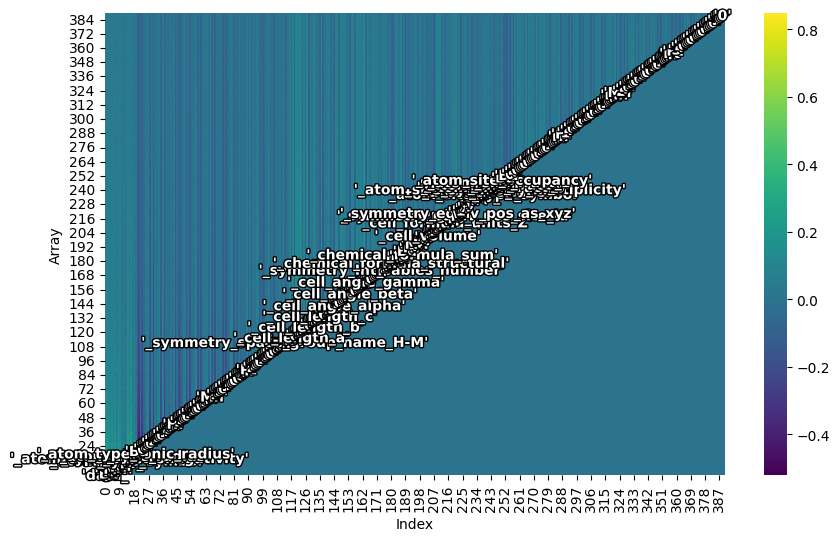

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patheffects

tokens = ["e"]
for c in cif_tokenized.numpy():
    token = id_to_token[c]
    tokens.append(repr(token))

# Select only the first 100 rows
range_min, range_max = 0, 1000
range_min_y = 0
print(matrix.shape)
matrix_100 = matrix[range_min:range_max, range_min_y:range_max]
tokens = tokens[range_min:range_max]
# matrix_100 = matrix

# Replace zeros with the smallest positive value
m = matrix_100.copy()
# m[m == 0] = np.min(m[m > 0])

# Create a heatmap using seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(m, annot=False, fmt=".4f", cmap="viridis", cbar=True, ax=ax)

# Invert the y-axis
plt.gca().invert_yaxis()

# Add labels on the heatmap
num_rows, num_cols = m.shape

for row in range(num_rows):
    # Calculate the middle y-coordinate
    # x = num_cols / 2  # Middle of the heatmap in x
    # Define text
    text = f"{tokens[row]}"
    # Place text on the heatmap
    txt = ax.text(
        row + 0.5 + range_min, row - 1.5, text, ha='center', va='center', color='white', fontsize=10, weight='bold'
    )
    # Add white outline
    txt.set_path_effects([
        patheffects.Stroke(linewidth=2, foreground='black'),
        patheffects.Normal()
    ])

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Array")
plt.show()

(390, 391)


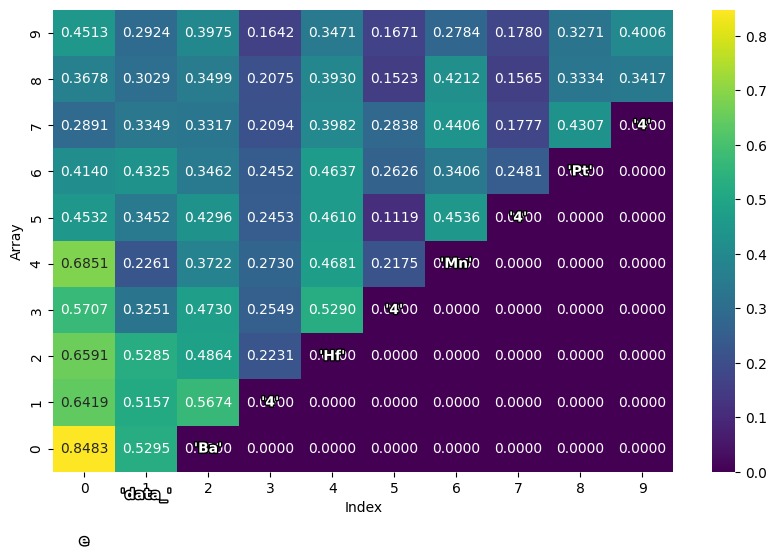

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patheffects

tokens = ["e"]
for c in cif_tokenized.numpy():
    token = id_to_token[c]
    tokens.append(repr(token))

# Select only the first 100 rows
range_min, range_max = 0, 10
range_min_y = 0
print(matrix.shape)
matrix_100 = matrix[range_min:range_max, range_min_y:range_max]
tokens = tokens[range_min:range_max]
# matrix_100 = matrix

# Replace zeros with the smallest positive value
m = matrix_100.copy()
# m[m == 0] = np.min(m[m > 0])

# Create a heatmap using seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(m, annot=True, fmt=".4f", cmap="viridis", cbar=True, ax=ax)

# Invert the y-axis
plt.gca().invert_yaxis()

# Add labels on the heatmap
num_rows, num_cols = m.shape

for row in range(num_rows):
    # Calculate the middle y-coordinate
    # x = num_cols / 2  # Middle of the heatmap in x
    # Define text
    text = f"{tokens[row]}"
    # Place text on the heatmap
    txt = ax.text(
        row + 0.5 + range_min, row - 1.5, text, ha='center', va='center', color='white', fontsize=10, weight='bold'
    )
    # Add white outline
    txt.set_path_effects([
        patheffects.Stroke(linewidth=2, foreground='black'),
        patheffects.Normal()
    ])

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Array")
plt.show()

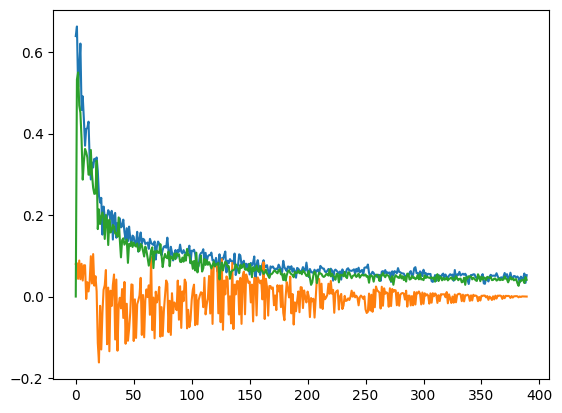

In [7]:
plt.plot(matrix[:,0][:])
plt.plot(np.mean(matrix[:,1:], axis=0)[:])
plt.plot(matrix[:,2][:])